#### Import the libraries

In [1]:
# Import libraries and packages
# Miscellaneous libraries
import numpy as np
import pandas as pd
import os
from datetime import datetime
import collections
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Visualization
import matplotlib.pyplot as plt
import seaborn as sn

In [110]:
#sys.path.append( '../')
#import utils.understanding_data as func

#### Define the path of the files

In [2]:
# Define the path of the data files
path = '../data/raw/'
path_git_commits = path + 'GIT_COMMITS.csv'
path_git_commits_changes = path + 'GIT_COMMITS_CHANGES.csv'
path_jira_issues = path + 'JIRA_ISSUES.csv'
path_sonar_analysis = path + 'SONAR_ANALYSIS.csv'
path_sonar_issues = path + 'SONAR_ISSUES.csv'
path_sonar_measures = path + 'SONAR_MEASURES.csv'

# Ensure the input file exist
assert os.path.isfile(path_git_commits), f'{path_git_commits} not found. Is it a file?'
assert os.path.isfile(path_git_commits_changes), f'{path_git_commits_changes} not found. Is it a file?'
assert os.path.isfile(path_jira_issues), f'{path_jira_issues} not found. Is it a file?'
assert os.path.isfile(path_sonar_analysis), f'{path_sonar_analysis} not found. Is it a file?'
assert os.path.isfile(path_sonar_issues), f'{path_sonar_issues} not found. Is it a file?'
assert os.path.isfile(path_sonar_measures), f'{path_sonar_measures} not found. Is it a file?'

#### Read the files

In [3]:
# Read the files
git_commits_changes = spark.read.csv(path_git_commits_changes,header=True).toPandas()
git_commits = pd.read_csv(path_git_commits)
jira_issues = pd.read_csv(path_jira_issues)
sonar_analysis = pd.read_csv(path_sonar_analysis)
sonar_issues = pd.read_csv(path_sonar_issues)
sonar_measures = pd.read_csv(path_sonar_measures)

#### Define selected variables

In [4]:
# Define variables of intereset for each dataframe
git_commits_changes_names = ['COMMIT_HASH','DATE','LINES_ADDED','LINES_REMOVED']
git_commits_names = ['PROJECT_ID','COMMIT_HASH','AUTHOR','AUTHOR_DATE','AUTHOR_TIMEZONE','COMMIT_MESSAGE']
jira_issues_names = ['HASH']
sonar_analysis_names = ['PROJECT_ID','ANALYSIS_KEY','REVISION']
sonar_issues_names = ['CREATION_ANALYSIS_KEY','SEVERITY','STATUS','EFFORT','MESSAGE','START_LINE','END_LINE','CLOSE_ANALYSIS_KEY']
sonar_measures_names = ['analysis_key','complexity' ,'cognitive_complexity', 'coverage', 'duplicated_blocks', 'duplicated_files', 
                        'duplicated_lines_density', 'violations','blocker_violations','critical_violations','major_violations','minor_violations','info_violations','false_positive_issues','open_issues','reopened_issues','confirmed_issues', 'sqale_debt_ratio','code_smells','bugs','reliability_rating','vulnerabilities','security_rating','files', 'comment_lines_density']           

In [5]:
# Select variables of interest
git_commits_changes = git_commits_changes[git_commits_changes_names]
git_commits = git_commits[git_commits_names]
jira_issues = jira_issues[jira_issues_names]
sonar_analysis = sonar_analysis[sonar_analysis_names]
sonar_issues = sonar_issues[sonar_issues_names]
sonar_measures = sonar_measures[sonar_measures_names]

In [6]:
# Define numercial types
numerical = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [7]:
# Modifying wrongly formated columns.
git_commits_changes[["LINES_ADDED","LINES_REMOVED"]] = git_commits_changes[["LINES_ADDED","LINES_REMOVED"]].apply(pd.to_numeric)

# Describe data

In [117]:
def save_outputs(fig,type_plot,variable,name_table):
    '''
    Objective:
        - Save png figures or csv files
    Input:
        - Fig : figure or file that want to be saved 
        - Type_plot : Barplot/histogram/heatmap/summary_cont/summary_cat/type_variables
        - Variable : Name of the table variable or None
        - Name_table : String name of the table
    Output: 
        - None
    '''
    # Path and name of the file/figure we want to save
    if variable == None :
        if type_plot == 'summary_cont' or type_plot == 'summary_cat':
            path = '../outputs/data_understanding'+"/"+type_plot[0:7]+"/"+name_table
            file_name = path+"/"+type_plot+".csv"
        else:
            path = '../outputs/data_understanding'+"/"+type_plot+"/"+name_table
            if type_plot == "type_variables":
                file_name = path+"/"+type_plot+".csv"
            else :
                file_name = path+"/"+type_plot+".png"
    else:
        path = '../outputs/data_understanding'+"/"+type_plot+"/"+name_table
        file_name = path+"/"+type_plot+"_"+variable+".png"
    
    # Directory creation if doesn't exists 
    try:
        os.makedirs(path)
    except OSError:
        print ("directory %s already created" % path)
    else:
        print ("Successfully created the directory %s" % path)
    
    # Save the figure/file 
    if (os.path.exists(file_name)== True):
        print ("Warning: Figure %s already created" % path)
        c = input('  Do you want to overwrite content?(y/n)')
        if c.lower() == 'n':
            print('Figure will not be overwritten, no action done')
            return
        if type_plot == 'summary_cont' or type_plot == 'summary_cat' or type_plot == "type_variables":
            fig.to_csv(file_name)
        else:
            plt.savefig(file_name, transparent=True)
    else:
        if type_plot == 'summary_cont' or type_plot == 'summary_cat' or type_plot == "type_variables":
            fig.to_csv(file_name)
        else:
            plt.savefig(file_name, transparent=True)
        
        print ("Successfully saved %s" % path)

In [118]:
def describe_variables(dataframe, numerical,table):
    '''
    Objective:
        - Obtain a stadistical summary of the variables
    Input:
        - Dataframe : Table with the selected columns
        - Numerical : Numerical types
        - Table : String name of the table 
    Output: 
        For continuous variables:
            - Count : Number of non-null observations
            - Mean : Mean of values
            - Std : Standard Deviation of the Values
            - min : Minimum Value
            - Max : Maximum Value
            - Percentiles 25%,50%,75%
        For categorical variables:
            - Count : Number of non-null observations
            Unique : Number of classes
            top : Class that has more ocurrences
            freq : Ocurrences of the top class
    '''
    dataframe_cont = dataframe.select_dtypes(include=numerical)
    dataframe_cat = dataframe.select_dtypes(exclude=numerical)
    
    cont_empty = dataframe_cont.empty
    cat_empty = dataframe_cat.empty
    
    if not cont_empty and not cat_empty:
        summary_cat = dataframe_cat.describe()
        save_outputs(summary_cat,"summary_cat",None,table)
        summary_cont = dataframe_cont.describe()
        save_outputs(summary_cont,"summary_cont",None,table)
        return (summary_cat, summary_cont)
    elif cont_empty and not cat_empty:
        summary_cat = dataframe_cat.describe()
        save_outputs(summary_cat,"summary_cat",None,table)
        return (summary_cat)
    elif not cont_empty and cat_empty:
        summary_cont = dataframe_cont.describe()
        save_outputs(summary_cont,"summary_cont",None,table)
        return (summary_cont)
    else:
        assert 'The dataframe is empty!'

def bar_plot(variable,dataframe,vertical,name_table):
    '''
    Objective:
        - Obtain a barplot of a variable
    Input:
        - Variable : data of the variable we want want to plot
        - Dataframe : All the table
        - Vertical : Is we want to plot the bar chart vertical (True) or horizontal(False)
        - Name_table : String name of the table 

    Output: 
        - Barplot
    '''
    labels = variable.unique()
    count = np.zeros(len(labels))

    for i in range(len(labels)):
        count[i] = dataframe[variable== labels[i]].count()[0]
    if vertical:
        fig = plt.barh(labels,count)
        plt.ylabel(variable.name)
        plt.xlabel('Count')       
    else:
        fig = plt.bar(labels,count)
        plt.xlabel(variable.name)
        plt.ylabel('Count')

    plt.title('Data of each '+variable.name)
    save_outputs(fig,'barplot',variable.name,name_table)
    
def plot_histogram(dataframe,numerical,name_table):
    '''
    Objective:
        - Plot a histogram of all numeric variables in dataframe
    Input:
        - Dataframe : Table with the selected columns
        - Numerical : Numerical types
        - Name_table : String name of the table 
    Output: 
        - Histogram
    '''
    dataframe = dataframe.select_dtypes(include=numerical)
    if dataframe.empty:
        print(f'There are no numerical variables in dataframe')
    else:
        for col in dataframe.columns:
            fig = plt.hist(x=dataframe[col], color='#F2AB6D', rwidth=0.85)
            plt.title(f'{col} histogram')
            plt.xlabel(f'{col}')
            plt.ylabel('Frequency')
            save_outputs(fig,'histogram',col,name_table)
            plt.show()
            
            

def plot_correlations(dataframe, numerical,name_table):
    '''
    Objective:
        - Plot a heatmap of all numeric variables in dataframe
    Input:
         - Dataframe : Table with the selected columns
        - Numerical : Numerical types
        - Name_table : String name of the table 
    Output: 
        - Heatmap
    '''

    dataframe = dataframe.select_dtypes(include=numerical)
    if dataframe.empty:
        print(f'There are no numerical variables in dataframe')
    else:
        corrMatrix = dataframe.corr()
        fig = sn.heatmap(corrMatrix, annot=True)
        save_outputs(fig,'heatmap',None,name_table)
        plt.show()

### Type of variables

In [119]:
print("---------- Git commits ----------")
save_outputs(git_commits[git_commits_names].dtypes,"type_variables",None,'git_commits')

---------- Git commits ----------
directory ../outputs/data_understanding/type_variables/git_commits already created
  Do you want to overwrite content?(y/n)y


In [121]:
print("---------- Git commits changes ----------")
save_outputs(git_commits_changes[git_commits_changes_names].dtypes,"type_variables",None,'git_commits_changes')

---------- Git commits changes ----------
directory ../outputs/data_understanding/type_variables/git_commits_changes already created
  Do you want to overwrite content?(y/n)Y


In [75]:
print("---------- Jira issues ----------")
save_outputs(jira_issues[jira_issues_names].dtypes,"type_variables",None,'jira_issues')

---------- Jira issues ----------
directory ../outputs/data_understanding/type_variables/jira_issues already created
  Do you want to overwrite content?(y/n)y


In [76]:
print("---------- Sonar analysis ----------")
save_outputs(sonar_analysis[sonar_analysis_names].dtypes,"type_variables",None,'sonar_analysis')

---------- Sonar analysis ----------
directory ../outputs/data_understanding/type_variables/sonar_analysis already created
  Do you want to overwrite content?(y/n)y


In [77]:
print("---------- Sonar issues ----------")
save_outputs(sonar_issues[sonar_issues_names].dtypes,"type_variables",None,'sonar_issues')

---------- Sonar issues ----------
directory ../outputs/data_understanding/type_variables/sonar_issues already created
  Do you want to overwrite content?(y/n)y


In [78]:
print("---------- Sonar measures ----------")
save_outputs(sonar_measures[sonar_measures_names].dtypes,"type_variables",None,'sonar_measures')

---------- Sonar measures ----------
directory ../outputs/data_understanding/type_variables/sonar_measures already created
  Do you want to overwrite content?(y/n)y


### Basic statistics

In [79]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Print basic statistics for the variables of interest for each table
print("---------- Git commits changes----------")
print(describe_variables(git_commits_changes,numerical,'git_commits'))

---------- Git commits changes----------
directory ../outputs/data_understanding/summary/git_commits already created
  Do you want to overwrite content?(y/n)y
                                     COMMIT_HASH                       DATE  \
count                                     857742                     857742   
unique                                    107909                     106521   
top     7d56abaf9b4a0e3e30a9afbf94e22f4b78d63bd0  2013-03-26 22:22:46+00:00   
freq                                        8979                       8979   

       LINES_ADDED LINES_REMOVED  
count       857742        857742  
unique        2614          2187  
top              0             0  
freq        175204        306450  


In [80]:
print("---------- Git commits ----------")
print(describe_variables(git_commits,numerical,'git_commits'))

---------- Git commits ----------
directory ../outputs/data_understanding/summary/git_commits already created
  Do you want to overwrite content?(y/n)y
directory ../outputs/data_understanding/summary/git_commits already created
  Do you want to overwrite content?(y/n)y
(              PROJECT_ID                               COMMIT_HASH  \
count              81072                                     81072   
unique                31                                     81072   
top     org.apache:felix  c38a00674aa1d5cd191e659f42e54696fc928e4a   
freq               15427                                         1   

                  AUTHOR           AUTHOR_DATE COMMIT_MESSAGE  
count              81038                 81072          81072  
unique               656                 80087          80549  
top     Carsten Ziegeler  2007-07-29T03:40:41Z       Javadoc.  
freq                5627                    20             40  ,        AUTHOR_TIMEZONE
count     81072.000000
mean       

In [81]:
print("---------- Jira issues ----------")
print(describe_variables(jira_issues,numerical,'jira_issues'))

---------- Jira issues ----------
directory ../outputs/data_understanding/summary/jira_issues already created
  Do you want to overwrite content?(y/n)y
                                            HASH
count                                      22007
unique                                        33
top     a08b83add286f9bbd10e6d3671143281031d2d94
freq                                        8285


In [82]:
print("---------- Sonar analysis ----------")
print(describe_variables(sonar_analysis,numerical,'sonar_analysis'))

---------- Sonar analysis ----------
directory ../outputs/data_understanding/summary/sonar_analysis already created
  Do you want to overwrite content?(y/n)y
               PROJECT_ID          ANALYSIS_KEY  \
count               67550                 66711   
unique                 31                 66711   
top     org.apache:cocoon  AV4rcikAG0XxMwG_WAho   
freq                10221                     1   

                                        REVISION  
count                                      67550  
unique                                     67550  
top     2a775e77718b72686dc51add8fd4ae95d2af44c6  
freq                                           1  


In [83]:
print("---------- Sonar issues ----------")
print(describe_variables(sonar_issues,numerical,'sonar_issues'))

---------- Sonar issues ----------
directory ../outputs/data_understanding/summary/sonar_issues already created
  Do you want to overwrite content?(y/n)y
directory ../outputs/data_understanding/summary/sonar_issues already created
  Do you want to overwrite content?(y/n)y
(       CREATION_ANALYSIS_KEY SEVERITY   STATUS  \
count                1024614  1024614  1024614   
unique                 18251        5        2   
top     AV1UBsiLt6tne_r59Tgv    MAJOR   CLOSED   
freq                   18879   493553   798745   

                                                  MESSAGE  \
count                                             1024614   
unique                                              42279   
top     Refactor this code to not nest more than 3 if/...   
freq                                                63175   

          CLOSE_ANALYSIS_KEY  
count                 798735  
unique                 16432  
top     AWRLNJb55esBcMsF1OWJ  
freq                   11079  ,              

In [84]:
print("---------- Sonar measures ----------")
print(describe_variables(sonar_measures,numerical,'sonar_measures'))

---------- Sonar measures ----------
directory ../outputs/data_understanding/summary/sonar_measures already created
  Do you want to overwrite content?(y/n)y
directory ../outputs/data_understanding/summary/sonar_measures already created
  Do you want to overwrite content?(y/n)y
(                analysis_key
count                  66711
unique                 66711
top     AV4rcikAG0XxMwG_WAho
freq                       1,           complexity  cognitive_complexity  coverage  duplicated_blocks  \
count   66683.000000          66683.000000   66677.0       66711.000000   
mean    18026.578753          15358.835625       0.0         947.564944   
std     28127.025568          23938.099550       0.0        1586.592958   
min         0.000000              0.000000       0.0           0.000000   
25%      2763.000000           1871.000000       0.0         111.000000   
50%      6560.000000           4348.000000       0.0         383.000000   
75%     24447.000000          21641.000000       

## Bar plots 

directory ../outputs/data_understanding/barplot/sonar_analysis already created
  Do you want to overwrite content?(y/n)y


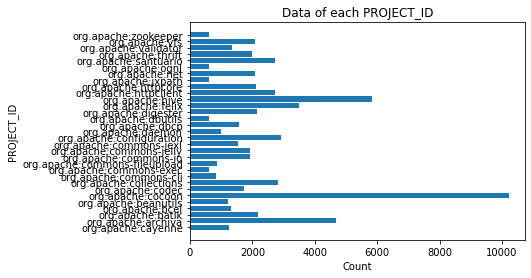

In [85]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plot bar plots for the categorical variables with few values
bar_plot(sonar_analysis["PROJECT_ID"],sonar_analysis,True,'sonar_analysis')

directory ../outputs/data_understanding/barplot/sonar_issues already created
  Do you want to overwrite content?(y/n)y


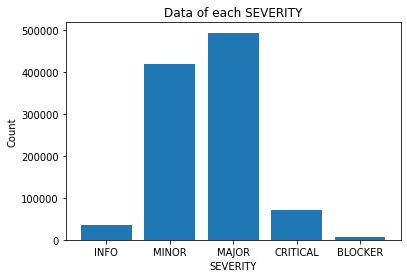

In [86]:
bar_plot(sonar_issues["SEVERITY"],sonar_issues,False,'sonar_issues')

directory ../outputs/data_understanding/barplot/sonar_issues already created
  Do you want to overwrite content?(y/n)y


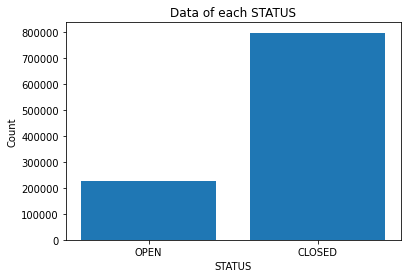

In [87]:
bar_plot(sonar_issues["STATUS"],sonar_issues,False,'sonar_issues')

## Histogram plots 

---------- Git commits ----------
directory ../outputs/data_understanding/histogram/git_commits already created
  Do you want to overwrite content?(y/n)y


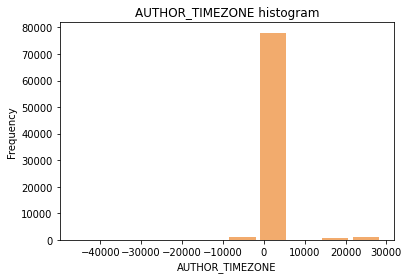

In [88]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plot histogram of all numeric variables in dataframe
print("---------- Git commits ----------")
plot_histogram(git_commits,numerical,'git_commits')

In [89]:
print("---------- Jira issues ----------")
plot_histogram(jira_issues,numerical,'jira_issues')

---------- Jira issues ----------
There are no numerical variables in dataframe


In [90]:
print("---------- Sonar analysis ----------")
plot_histogram(sonar_analysis,numerical,'sonar_analysis')

---------- Sonar analysis ----------
There are no numerical variables in dataframe


---------- Sonar issues ----------
directory ../outputs/data_understanding/histogram/sonar_issues already created
  Do you want to overwrite content?(y/n)y


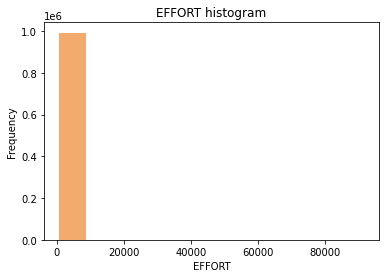

directory ../outputs/data_understanding/histogram/sonar_issues already created
  Do you want to overwrite content?(y/n)y


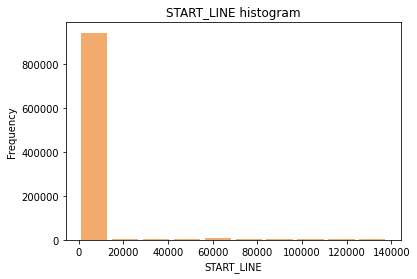

directory ../outputs/data_understanding/histogram/sonar_issues already created
  Do you want to overwrite content?(y/n)y


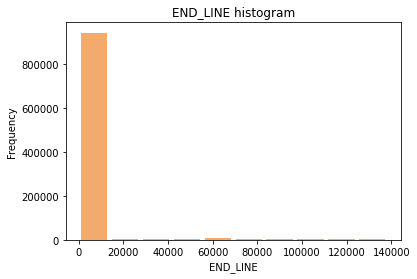

In [91]:
print("---------- Sonar issues ----------")
plot_histogram(sonar_issues,numerical,'sonar_issues')

---------- Sonar measures ----------
directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


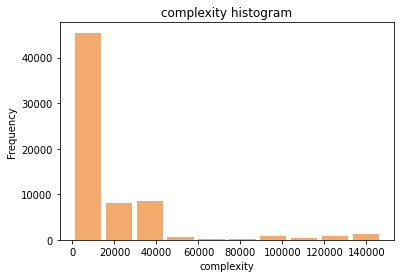

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


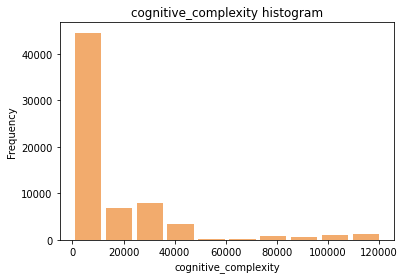

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


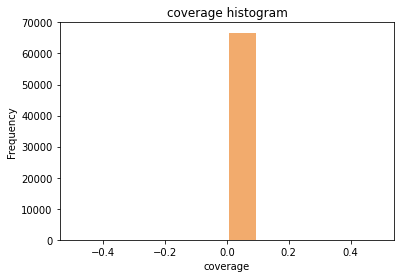

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


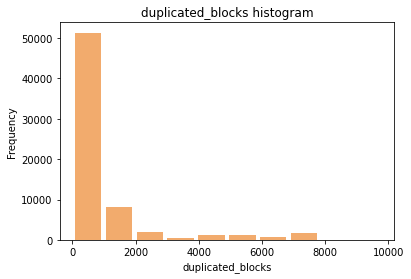

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


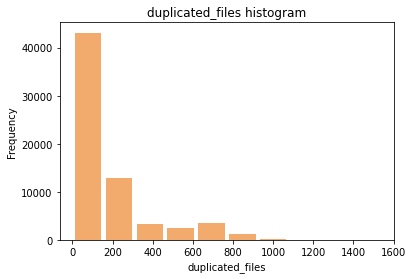

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


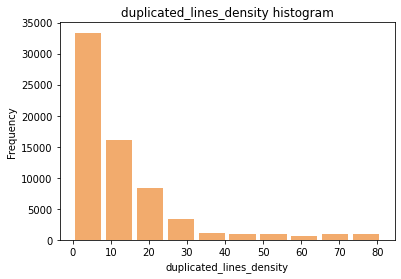

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


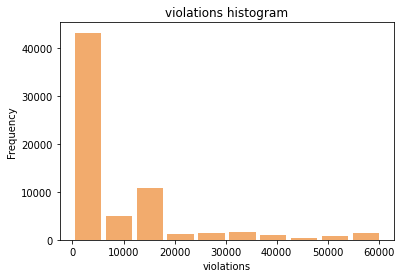

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


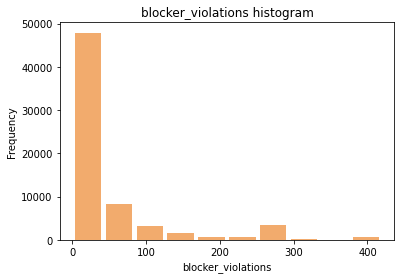

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


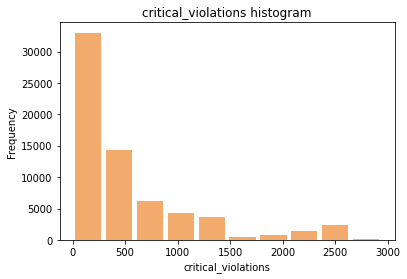

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


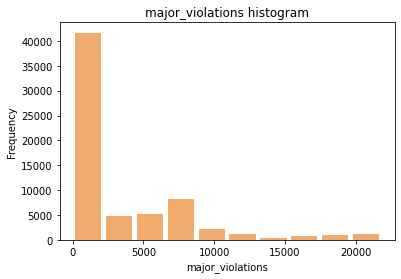

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


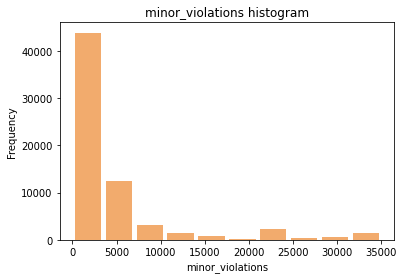

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


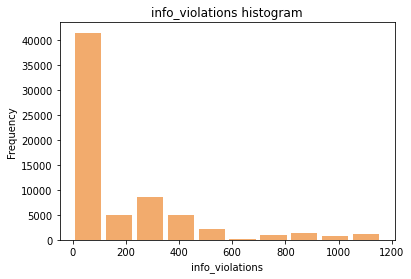

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


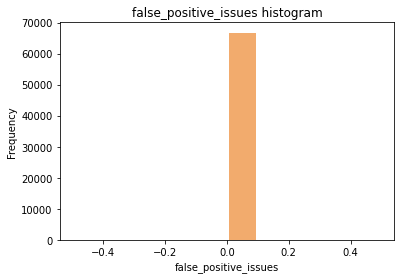

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


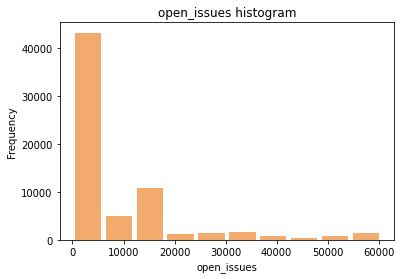

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


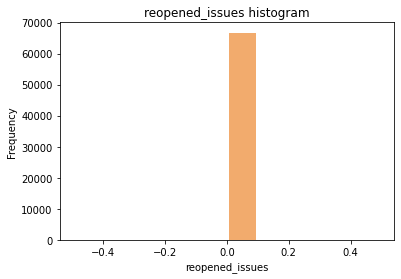

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


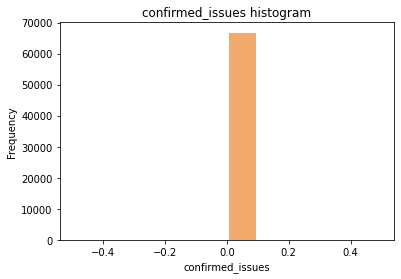

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


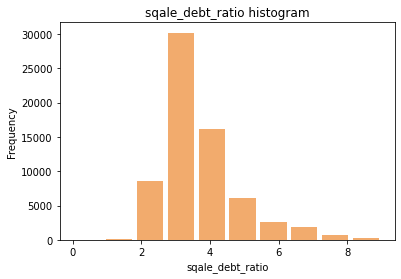

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


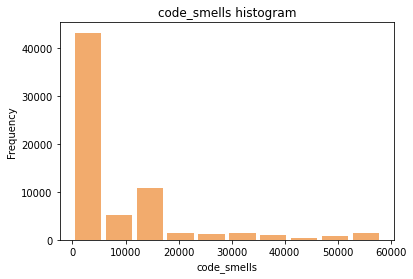

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


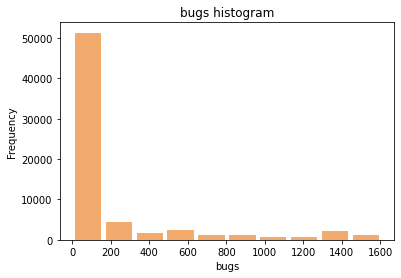

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


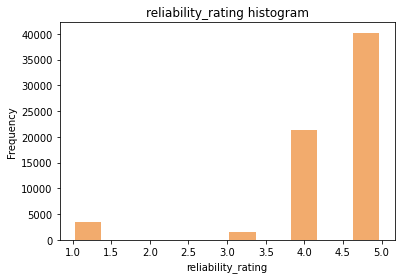

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


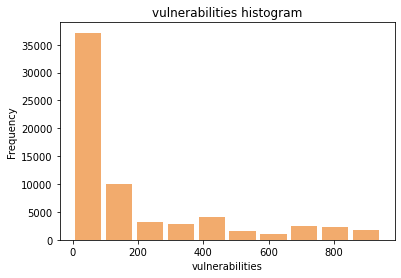

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


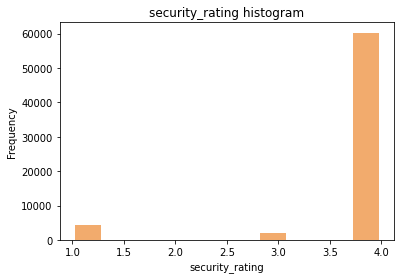

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


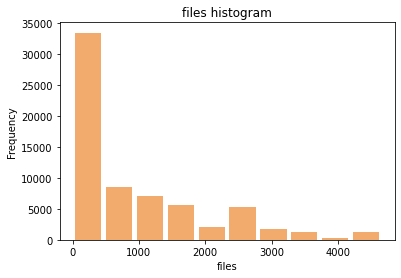

directory ../outputs/data_understanding/histogram/sonar_measures already created
  Do you want to overwrite content?(y/n)y


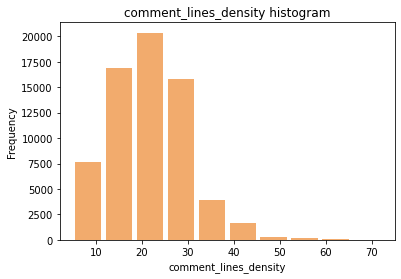

In [92]:
print("---------- Sonar measures ----------")
plot_histogram(sonar_measures,numerical,'sonar_measures')

## Correlation plots 

---------- Git commits ----------
directory ../outputs/data_understanding/heatmap/git_commits already created
  Do you want to overwrite content?(y/n)y


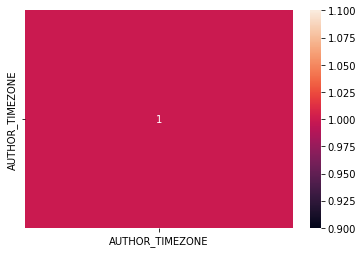

In [93]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plot correlation of all numeric variables in dataframe
print("---------- Git commits ----------")
plot_correlations(git_commits,numerical,'git_commits')

In [94]:
print("---------- Jira issues ----------")
plot_correlations(jira_issues,numerical,'jira_issues')

---------- Jira issues ----------
There are no numerical variables in dataframe


In [95]:
print("---------- Sonar analysis ----------")
plot_correlations(sonar_analysis,numerical,'sonar_analysis')

---------- Sonar analysis ----------
There are no numerical variables in dataframe


---------- Sonar issues ----------
directory ../outputs/data_understanding/heatmap/sonar_issues already created
  Do you want to overwrite content?(y/n)y


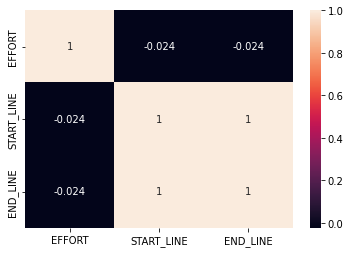

In [96]:
print("---------- Sonar issues ----------")
plot_correlations(sonar_issues,numerical,'sonar_issues')

---------- Sonar measures ----------
directory ../outputs/data_understanding/heatmap/sonar_measures already created
  Do you want to overwrite content?(y/n)y


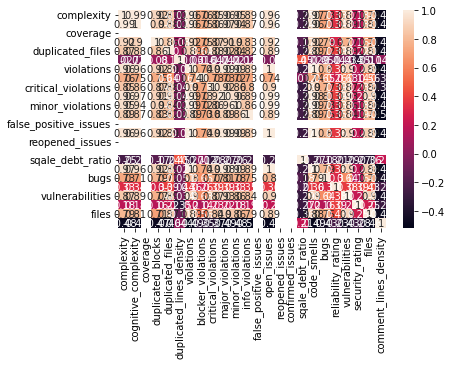

In [97]:
print("---------- Sonar measures ----------")
plot_correlations(sonar_measures,numerical,'sonar_measures')

#  Checking data quality

In this section, an evaluation of the overall quality of the data for each table used in the project will be perfomed. To ease the comprehension of the code,a list indicating which tests will be perfomed for each table:

**AUXILIAR FUNCTIONS**

In [17]:
def initialize_doc(filename,dataset_name):
    '''
    Objective:
        - Create/empty a document that will store the quality analysis results of a table
          and introduce the different test that will be performed.
    Input:
        - filename : Name of file that will be created.
        - dataset_name: Name of the dataset from which we want to create the document.
    Output: 
        - String containing the quality test that will be performed for the selected table.
    '''
    # First, we create the folder where the results will be stored.
    path = '../reports/figures/data_understanding/data_quality/'
    if not os.path.isdir(path): 
        os.makedirs(path)
    # Then we create the intro for the desired dataset.
    title= "-"*10 + " " + dataset_name + " quality analysis " + "-"*10
    title = title.upper()
    title_and_summary = '\n'.join([title,"\n","The test(s) that will be performed for the "+dataset_name.upper()+" table are:"])
    separator = "--------------------------------------------------------------------------------"
    if dataset_name == "Sonar measures": tests = '\n · '.join(["Foreign key constraint","Presence of NAs"])
    elif dataset_name == "Sonar issues": tests = "Presence of NAs"
    elif dataset_name == "Sonar analysis": tests = '\n · '.join(["Primary key constraint","Foreign key constraint"])
    elif dataset_name == "Jira issues": tests = "Foreign key constraint"
    elif dataset_name == "Git commits": tests = '\n · '.join(["Primary key constraint","Date range of commits","Number of missing authors"])
    elif dataset_name == "Git commits changes": tests = '\n · '.join(["Date range of commits","Foreign key constraint","Presence of NAs"])
    intro = '\n · '.join([title_and_summary,tests + "\n"+ separator])
    # Finally the intro is written into the file.
    f = open(path+filename, "w")
    f.write(intro)
    f.close()
    return intro

def write_test_results(filename,test_name,results):
    '''
    Objective:
        - Append the results of a certain quality test into the pertinent file.
    Input:
        - filename : Name of file to apend the results.
        - test_name: Name of the quality test from which the results are.
        - results: Results obtained from test.
    Output: 
        - String containing a well-formated presentation of the results from the quality test.
    '''
    path = '../reports/figures/data_understanding/data_quality/'
    title= "\n"+ "#"*10 + " " + test_name + " test results "+ "#"*10
    title = title.upper()
    separator = "-"*40
    if test_name == "FK":
        if len(results[1]) == 0:
            test_results = '\n · '.join([title,results[0] + "\n"+ separator])
        else:
            results[1] = list(filter(None, results[1]))
            fk_txt = " The FK without references are:" + "\n[" + ','.join(results[1]) + "]"
            test_results = '\n · '.join([title,results[0], fk_txt + "\n"+ separator])
    else:
        test_results = '\n · '.join([title,results + "\n"+ separator])
    f = open(path+filename,"a")
    f.write(test_results)
    f.close()
    return test_results

def write_extra_info(filename,test_name,result,intro):
    '''
    Objective:
        - Append information about the extra test performed to certain tables to their specific file.
    Input:
        - filename : Name of file to apend the extra info.
        - test_name: Name of the performed test.
        - result: Result of the extra test.
        - intro: Brief explanation on why and what test was performed.
    Output: 
        - None.
    '''
    path = '../reports/figures/data_understanding/data_quality/'
    # Writting the intro in the doc.
    f = open(path+filename,"a")
    f.write("\n"+intro)
    f.close()
    print(intro)
    print(write_test_results(filename,test_name,result),end = "")
    
        
    
def check_PK(dataset,pk):
    '''
    Objective:
        - Evaluate if a table has repeated/missing values in the Primary Key variable.
    Input:
        - dataset : Pandas dataset that wants to be analyzed (One table of the TechDebt DS).
        - pk : Name of the Primary Key of the table.
   Output: 
    For tables without NA problems:
        - String indicating that there isn't any problem.
    For tables with NA problems:
        - String containg the percentage of repeated values.
    '''
    if len(dataset[pk].unique()) != len(dataset):
        result = "There are "+ str(round((len(dataset)-len(dataset[pk].unique()))/len(dataset)*100,4)) + "% rows with a non-unique PK value."
    else: result = "All the PK are unique."
    return result
        
def check_NAs(dataset,columns_of_interest):
    '''
    Objective:
        - Evaluate if a table has missing values in a subset of columns.
    Input:
        - dataset : Pandas dataset that wants to be analyzed (One table of the TechDebt DS).
        - columns_of_interest : Names of the columns to be checked.
    Output: 
        For tables without NA problems:
            - String indicating that there aren't any missing values.
        For tables with NA problems:
            - String containg the columns with missing values and their percentage.
            - List with the same info than the string.
        
    '''
    cols_with_NA = [(col,dataset[col].isna().sum()/len(dataset[col])*100) for col in columns_of_interest if dataset[col].isna().sum() > 0]
    if len(cols_with_NA) != 0:
        result = "The columns that contain NAs are:\n" + '\n'.join(" "*6+x[0]+" → "+str(round(x[1],4))+"%" for x in cols_with_NA)
    else: result = "There aren't NAs in the table."
    return result,cols_with_NA

def check_missing_authors(dataset,column):
    '''
    Objective:
        - Evaluate if a table has missing authors in the given column.
    Input:
        - dataset : Pandas dataset that wants to be analyzed (One table of the TechDebt DS).
        - column : Names of the columns that contains the authors.
    Output: 
        For tables without missing authors problems:
            - String indicating that there aren't any missing values.
        For tables with missing authors problems:
            - String containg the percentage of missing values.
    '''
    no_authors = sum(dataset[column] == "No Author") + sum(dataset[column].isna())
    if no_authors != 0:
        result = "The percentage of missing authors is:" + str(round(no_authors/len(git_commits)*100,3))+"%."
    else: result("All the rows contain an author.")
    return result


def check_dates(dataset,column,ub,lb,date_format):
    '''
    Objective:
        - Evaluate if a all the values of a column that contain dates are between an upper and a lower bound.
          (The dates are in 'YYYY-mm-ddTHH:MM:SSZ' format).
    Input:
        - dataset : Pandas dataset that wants to be analyzed (One table of the TechDebt DS).
        - column : Column name that contain the dates.
        - ub: Upper bound for the dates (Datetime object).
        - lb: Year lower bound for the dates (in string format).
        -date_format: Index indicating whether a space or "T" calendar-hour separation is used.
    Output: 
        For tables without range problems:
            - String indicating that there isn't any problem.
        For tables with range problems:
            - String indicating the percentage of dates outside the range.
    '''
    aux = dataset.dropna()
    if date_format == 1:
        date_style = "%Y-%m-%dT%H:%M:%SZ"
    else: date_style = "%Y-%m-%d %H:%M:%S"
    if min(aux[column]).split("-")[0] < lb or datetime.strptime(max(aux[column]).split("+")[0],date_style) > ub:
        out_range = len(aux[(aux[column].split("-")[0] < lb) | (datetime.strptime(aux[column],"%Y-%m-%dT%H:%M:%SZ") >ub)])
        result = "There are "+str(round(out_range/len(dataset)*100,3))+ "date outside the specified range."
    else: result = "All the dates are in the specified range."
    return result
    

def check_FK(dataset,fk,dataset_w_pk,pk):
    '''
    Objective:
        - Evaluate if a table has a foreign key that don't reference any primary key from another table.
    Input:
        - dataset : Pandas dataset that wants to be analyzed (One table of the TechDebt DS).
        - fk : Name of the Foreign Key from the table.
        - dataset_w_pk: Pandas dataset that contains the values referenced in the FK of "dataset".
        - pk: Name of the Primary Key of "dataset_w_pk".
    Output: 
        For tables without FK problems:
            - String indicating that there isn't any problem.
            - An empty list
        For tables with NA problems:
            - String inidicating the percentage of FK violations.
            - List of all the fk that aren't referenced.
        
    '''
    pks_list = list(dataset_w_pk[pk].unique())
    fk_violations = [x for x in list(dataset[fk].unique()) if x not in pks_list]
    if len(fk_violations) != 0:
        result = str(round(len(fk_violations)/len(dataset)*100,3)) + "% of the FKs are unreferenced."
    else: result = "All the FK values have an associated PK."
    return result,fk_violations

**SONAR_MEASURES:**

In [18]:
## SONAR MEASURES
sonar_measures_txt = "sonar_measures_quality_analysis.txt"
print(initialize_doc(sonar_measures_txt,"Sonar measures"),end = "")
t1_result,fk_violations = check_FK(sonar_measures,'analysis_key',sonar_analysis,'ANALYSIS_KEY')
print(write_test_results(sonar_measures_txt,"FK",[t1_result,fk_violations]),end = "")
t2_result,_ = check_NAs(sonar_measures,sonar_measures_names)
print(write_test_results(sonar_measures_txt,"NA",t2_result),end = "")

---------- SONAR MEASURES QUALITY ANALYSIS ----------


The test(s) that will be performed for the SONAR MEASURES table are:
 · Foreign key constraint
 · Presence of NAs
--------------------------------------------------------------------------------
########## FK TEST RESULTS ##########
 · All the FK values have an associated PK.
----------------------------------------
########## NA TEST RESULTS ##########
 · The columns that contain NAs are:
      complexity → 0.042%
      cognitive_complexity → 0.042%
      coverage → 0.051%
      duplicated_lines_density → 0.039%
      files → 0.039%
      comment_lines_density → 0.039%
----------------------------------------

**SONAR_ISSUES** 

In [19]:
## SONAR ISSUES
sonar_issues_txt = "sonar_issues_quality_analysis.txt"
print(initialize_doc(sonar_issues_txt,"Sonar issues"),end = "")
t1_result,NA_columns = check_NAs(sonar_issues, sonar_issues_names)
print(write_test_results(sonar_issues_txt,"NA",t1_result),end = "")

---------- SONAR ISSUES QUALITY ANALYSIS ----------


The test(s) that will be performed for the SONAR ISSUES table are:
 · Presence of NAs
--------------------------------------------------------------------------------
########## NA TEST RESULTS ##########
 · The columns that contain NAs are:
      EFFORT → 3.1143%
      START_LINE → 4.6714%
      END_LINE → 4.6714%
      CLOSE_ANALYSIS_KEY → 22.0453%
----------------------------------------

Checking if all the rows that don't have an starting line also don't have and end line.

In [20]:
extra_intro = "As the % of START_LINE is equal to the one in the END_LINE, we will check if the rows match."
aux_start_end = sonar_issues[sonar_issues.START_LINE.notna()]
if aux_start_end.END_LINE.isna().sum() != 0:
    result = "There are rows with an START_LINE value that are missing the END_LINE value"
else: result = "All the rows match!"
write_extra_info(sonar_issues_txt,"Extra check: missing values",result,extra_intro)

As the % of START_LINE is equal to the one in the END_LINE, we will check if the rows match.

########## EXTRA CHECK: MISSING VALUES TEST RESULTS ##########
 · All the rows match!
----------------------------------------

Checking if all the rows with missing CLOSE_ANALYSIS_KEY have STATUS = OPEN

In [21]:
extra_intro = "We will check if all the rows with missing CLOSE_ANALYSIS_KEY have STATUS = OPEN."
aux_cak = sonar_issues[sonar_issues.CLOSE_ANALYSIS_KEY.isna()]
if sum(aux_cak.STATUS == "OPEN")!= len(aux_cak):
    result = "There are " + str(len(aux_cak) - sum(aux_cak.STATUS == "OPEN"))+ " closed issues without closing analysis keys."
else: result = "All the rows match!"
write_extra_info(sonar_issues_txt,"Extra check: missing values",result,extra_intro)

We will check if all the rows with missing CLOSE_ANALYSIS_KEY have STATUS = OPEN.

########## EXTRA CHECK: MISSING VALUES TEST RESULTS ##########
 · There are 10 closed issues without closing analysis keys.
----------------------------------------

**SONAR_ANALYSIS**

In [22]:
## SONAR ANALYSIS
sonar_analysis_txt = "sonar_analyisis_quality_analysis.txt"
print(initialize_doc(sonar_analysis_txt,"Sonar analysis"),end = "")
t1_result = check_PK(sonar_analysis,'ANALYSIS_KEY')
print(write_test_results(sonar_analysis_txt,"PK",t1_result),end = "")
t2_result,fk_violations = check_FK(sonar_analysis,'REVISION',git_commits,'COMMIT_HASH')
print(write_test_results(sonar_analysis_txt,"FK",[t2_result,fk_violations]),end = "")

---------- SONAR ANALYSIS QUALITY ANALYSIS ----------


The test(s) that will be performed for the SONAR ANALYSIS table are:
 · Primary key constraint
 · Foreign key constraint
--------------------------------------------------------------------------------
########## PK TEST RESULTS ##########
 · There are 1.2406% rows with a non-unique PK value.
----------------------------------------
########## FK TEST RESULTS ##########
 · 39.172% of the FKs are unreferenced.
 ·  The FK without references are:
[b9988a83e364b9b470873dff8996dcf401d08dc4,5d351ea375f2b8d4ca0ae40b887392915983121a,2bb54cc863c9c599e316ae5da7ba1a77f42e9402,68b851d2adbbeee6014d1c37b9c07fdb4fc6820f,e6c057bd6a04ec286d4ac4da5d2a82696868b937,7e5a5c7e3bab469287f261774b9f797fe64a579b,ec6811f46c0ea135d565f5b2476c134c19fb6fff,a3e5cc4cf539a744997284f695841c59b80236a4,d10db9655d5c8dd4ba3391a55f063f4034450927,645a7a6d9287eef969b35b2119acac38e6ee647b,34bc37a3ca9e863360cb3c2ed68b6aec6c4e15e9,c787a2a9ee54f4b9e604ae652c8805d7d5d43388,6ba

As problems in the PK were observed, a futher quality examination has been performed. 
After a quick exploration, we noticed the presence of null values as PK in the analysis.
Thus, we wanted to evaluate wheather this was the only present problem and the numbers of rows affected by this phenomenon.

In [23]:
extra_intro = "Further exploration on the PK repeated values"
if len(sonar_analysis[sonar_analysis['ANALYSIS_KEY'].notna()]) == len(sonar_analysis[sonar_analysis['ANALYSIS_KEY'].notna()].ANALYSIS_KEY.unique()):
    result = "All the repeated values on the PK variable are NAs." 
    result = result + "\n"+" "*3 +"The percentage of NA PK is: "+ str(round(sum(sonar_analysis.ANALYSIS_KEY.isna())/len(sonar_analysis)*100,3))+"%."
else: result = "The repeated values on the PK column are not NAs."
write_extra_info(sonar_analysis_txt,"Extra check: pk violation",result,extra_intro)

Further exploration on the PK repeated values

########## EXTRA CHECK: PK VIOLATION TEST RESULTS ##########
 · All the repeated values on the PK variable are NAs.
   The percentage of NA PK is: 1.242%.
----------------------------------------

**[EXTRA]**

In [24]:
extra_intro = "After reporting the FK problem to Davide, he told us that he wanted to observe" \
              "wheteher all the rows that contained such problems were related to a an specific" \
              "project or affected to serveral ones. Thus, we performed such analysis:"
projects_with_fk_problems = [sonar_analysis[sonar_analysis.REVISION == x].PROJECT_ID for x in fk_violations]
projects_with_fk_problems = collections.Counter([x.values[0] for x in projects_with_fk_problems])
aux = collections.Counter(sonar_analysis.PROJECT_ID.values)
result = "The % of FK violations per projects are:\n" + '\n'.join(" "*6+x+" → "+str(round(projects_with_fk_problems[x]/aux[x]*100,4))+"%" for x in list(projects_with_fk_problems.keys()))
write_extra_info(sonar_analysis_txt,"Extra check: fk violation",result,extra_intro)

After reporting the FK problem to Davide, he told us that he wanted to observewheteher all the rows that contained such problems were related to a an specificproject or affected to serveral ones. Thus, we performed such analysis:

########## EXTRA CHECK: FK VIOLATION TEST RESULTS ##########
 · The % of FK violations per projects are:
      org.apache:cayenne → 88.4035%
      org.apache:archiva → 76.9231%
      org.apache:batik → 100.0%
      org.apache:cocoon → 100.0%
      org.apache:felix → 85.3009%
      org.apache:hive → 28.9411%
      org.apache:santuario → 100.0%
      org.apache:thrift → 97.6012%
----------------------------------------

**JIRA_ISSUES** 

In [25]:
## JIRA ISSUES
jira_issues_txt = "jira_issues_quality_analysis.txt"
print(initialize_doc(jira_issues_txt,"Jira issues"),end = "")
t1_result,fk_violations = check_FK(jira_issues,'HASH',git_commits,'COMMIT_HASH')
print(write_test_results(jira_issues_txt,"FK",[t1_result,fk_violations]),end = "")

---------- JIRA ISSUES QUALITY ANALYSIS ----------


The test(s) that will be performed for the JIRA ISSUES table are:
 · Foreign key constraint
--------------------------------------------------------------------------------
########## FK TEST RESULTS ##########
 · 0.127% of the FKs are unreferenced.
 ·  The FK without references are:
[3a4b72c2e73298e98e7b24a54b4bcf66d4abf55d,5e900960d38377d2df439dfc35102d459c32f811,f1a1459f19685a71e1d7d7d7dc2de0c3cc2ea077,04daba9c6b85b3a1903324bdbc8948b33f9b0a4f,2004bc4ddab08de9c92cf9c26ac07f2c35074050,8d6852452de03500dba8e8edf4bf5b5faad31dbf,27357a780007d35ebe5cdf0ac9bfbf157425c377,fea8c46739b307f30152e50dc1f30f01237a89bb,73257bdb3bdf9b391353173411ab7e2362c6534a,8fa525dd420dcfcec0341a445b0d06c811731d99,d28e5d59c0366ddfbbdd05d6d30f39f1df99e300,f4903cf1df0a144f61073af038806b7ae8d4f8c0,3425aa853e026a05c9b6d920efe230a869fee0b2,eeae97a2141dbe1bec8eaab4adfc5338ee2cb38c,49b288fdff2643dedcdad57e67cd6129140866c0,1d1d4e988afca3499224f785a2740f35d7cb6e1c,53037

**GIT_COMMITS**

In [26]:
## GIT COMMITS
git_commits_txt = "git_commits_quality_analysis.txt"
print(initialize_doc(git_commits_txt,"Git commits"),end = "")
t1_result = check_PK(git_commits,'COMMIT_HASH')
print(write_test_results(git_commits_txt,"PK",t1_result),end = "")
t2_result = check_dates(git_commits,'AUTHOR_DATE',datetime.today(),'1999',1)
print(write_test_results(git_commits_txt,"DATES RANGE",t2_result),end = "")
t3_result = check_missing_authors(git_commits,'AUTHOR')
print(write_test_results(git_commits_txt,"MISSING AUTHORS",t3_result),end = "")

---------- GIT COMMITS QUALITY ANALYSIS ----------


The test(s) that will be performed for the GIT COMMITS table are:
 · Primary key constraint
 · Date range of commits
 · Number of missing authors
--------------------------------------------------------------------------------
########## PK TEST RESULTS ##########
 · All the PK are unique.
----------------------------------------
########## DATES RANGE TEST RESULTS ##########
 · All the dates are in the specified range.
----------------------------------------
########## MISSING AUTHORS TEST RESULTS ##########
 · The percentage of missing authors is:0.064%.
----------------------------------------

**GIT_COMMITS_CHANGES**

In [ ]:
## GIT COMMITS CHANGES
git_commits_changes_txt = "git_commits_changes_quality_analysis.txt"
print(initialize_doc(git_commits_changes_txt,"Git commits changes"),end = "")
t1_result = check_dates(git_commits_changes,'DATE',datetime.today(),'1999',2)
print(write_test_results(git_commits_changes_txt,"DATES RANGE",t1_result),end = "")
t2_result,fk_violations = check_FK(git_commits_changes,'COMMIT_HASH',git_commits,'COMMIT_HASH')
print(write_test_results(git_commits_changes_txt,"FK",[t2_result,fk_violations]),end = "")
t3_result,_ = check_NAs(git_commits_changes,git_commits_changes_names)
print(write_test_results(git_commits_changes_txt,"NA",t3_result),end = "")

---------- GIT COMMITS CHANGES QUALITY ANALYSIS ----------


The test(s) that will be performed for the GIT COMMITS CHANGES table are:
 · Date range of commits
 · Foreign key constraint
 · Presence of NAs
--------------------------------------------------------------------------------
########## DATES RANGE TEST RESULTS ##########
 · All the dates are in the specified range.
----------------------------------------

As the percentage of NAs is the same for all the columns, we will check if a row misses one value, misses all.

In [ ]:
extra_intro = "We will check if the NAs from different columns belong to the same rows."
aux_na = git_commits_changes[git_commits_changes.COMMIT_HASH.isna()]
na_bool = aux_na.isnull().all().all()
if na_bool:
    result = "If a row contains a NA value, there are also NAs for the rest of the columns."
else: result = "The NAs of the columns do not belong to a same subset of rows."
write_extra_info(git_commits_changes_txt,"Extra check: missing values",result,extra_intro)